In [1]:
import numpy as np
import scipy
import xarray as xr
import sys
from calendar import monthrange
import os
import matplotlib.pyplot as plt
import cmocean
from scipy import stats,signal


In [2]:
#%% Define directory
WRF_DIRECTORY_26 = "/scratch/mgomez/Hurricane/idealized/test/sst_26_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY_28_mod = "/scratch/mgomez/Hurricane/idealized/test/sst_28_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY_30 = "/scratch/mgomez/Hurricane/idealized/test/sst_30_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY_28 = "/scratch/mgomez/Hurricane/idealized/test/sst_27_skipd01_skipCoLES_ndg/"
WRF_DIRECTORY_27 = "/scratch/mgomez/Hurricane/idealized/test/sst_27real_skipd01_skipCoLES_ndg/"

WRF_DIRS = [WRF_DIRECTORY_26,WRF_DIRECTORY_28_mod,WRF_DIRECTORY_30,WRF_DIRECTORY_28,WRF_DIRECTORY_27]

# Height
hgt_file = "/scratch/mgomez/Hurricane/idealized/test/sst_26_skipd01_skipCoLES_ndg/hgt_file.nc"

# Precursor simulation
WRF_FILES_prec = 'merged_d01.nc_prec' 

# Domain 01 (dx=1.5km)
WRF_FILES_meso = 'merged_d01.nc' 


# Maximum height to save
iz_MMaax = 5

In [3]:
#%% Extract data from each simulation
for i_d in np.arange(len(WRF_DIRS)):
    # Precursor simulation
    ds=xr.open_dataset(WRF_DIRS[i_d]+WRF_FILES_prec,decode_times=False)
    # Wind speed
    u_tmp = ds['U']
    u_tmp = np.array(u_tmp[:,0,:,:,:])
    v_tmp = ds['V']
    v_tmp = np.array(v_tmp[:,0,:,:,:])
    w_tmp = ds['W']
    w_tmp = np.array(w_tmp[:,0,:,:,:])
    time_temp = np.array(ds['Times'])
    # De-stagger wind speed
    u_tmp = 0.5*(u_tmp[:,:,:,0:np.shape(u_tmp)[3]-1]+u_tmp[:,:,:,1:np.shape(u_tmp)[3]])
    v_tmp = 0.5*(v_tmp[:,:,0:np.shape(v_tmp)[2]-1,:]+v_tmp[:,:,1:np.shape(v_tmp)[2],:])
    w_tmp = 0.5*(w_tmp[:,0:np.shape(w_tmp)[1]-1,:,:]+w_tmp[:,1:np.shape(w_tmp)[1],:,:])
    # Save data
    if i_d == 0:
        # Only keep data within heights of interest
        u_tmp = u_tmp[:,0:iz_MMaax,:,:]
        v_tmp = v_tmp[:,0:iz_MMaax,:,:]
        w_tmp = w_tmp[:,0:iz_MMaax,:,:]
        # Create new variables
        u_prec = np.zeros_like(u_tmp) + u_tmp
        v_prec = np.zeros_like(v_tmp) + v_tmp
        w_prec = np.zeros_like(w_tmp) + w_tmp
        Time_prec = []
        Time_prec.append(time_temp)
        # Domain dimensions
        dx_prec = ds.DX
        n_x_prec = dx_prec*np.arange(0,np.shape(u_prec)[3])
        n_y_prec = dx_prec*np.arange(0,np.shape(v_prec)[2])
    else:
        # Only keep data within heights of interest
        u_tmp = u_tmp[:,0:iz_MMaax,:,:]
        v_tmp = v_tmp[:,0:iz_MMaax,:,:]
        w_tmp = w_tmp[:,0:iz_MMaax,:,:]
        # Append data to saved variables
        u_prec = np.append(u_prec,u_tmp,axis=0)
        v_prec = np.append(v_prec,v_tmp,axis=0)
        w_prec = np.append(w_prec,w_tmp,axis=0)
        Time_prec.append(time_temp)
    ds.close()
    ds = 0.0
    
    
    # Mesoscale domain in final simulation
#     if not('sst_27real' in WRF_DIRS[i_d]):
    ds=xr.open_dataset(WRF_DIRS[i_d]+WRF_FILES_meso,decode_times=False)
    # Wind speed
    u_tmp = ds['U']
    u_tmp = np.array(u_tmp[:,0,:,:,:])
    v_tmp = ds['V']
    v_tmp = np.array(v_tmp[:,0,:,:,:])
    w_tmp = ds['W']
    w_tmp = np.array(w_tmp[:,0,:,:,:])
    time_temp = np.array(ds['Times'])
    # De-stagger wind speed
    u_tmp = 0.5*(u_tmp[:,:,:,0:np.shape(u_tmp)[3]-1]+u_tmp[:,:,:,1:np.shape(u_tmp)[3]])
    v_tmp = 0.5*(v_tmp[:,:,0:np.shape(v_tmp)[2]-1,:]+v_tmp[:,:,1:np.shape(v_tmp)[2],:])
    w_tmp = 0.5*(w_tmp[:,0:np.shape(w_tmp)[1]-1,:,:]+w_tmp[:,1:np.shape(w_tmp)[1],:,:])
    # Save data
    if i_d == 0:
        # Only keep data within heights of interest
        u_tmp = u_tmp[:,0:iz_MMaax,:,:]
        v_tmp = v_tmp[:,0:iz_MMaax,:,:]
        w_tmp = w_tmp[:,0:iz_MMaax,:,:]
        # Create new variables
        u_meso = np.zeros_like(u_tmp) + u_tmp
        v_meso = np.zeros_like(v_tmp) + v_tmp
        w_meso = np.zeros_like(w_tmp) + w_tmp
        Time_meso = []
        Time_meso.append(time_temp)
        # Domain dimensions
        dx_meso = ds.DX
        n_x_meso = dx_meso*np.arange(0,np.shape(u_meso)[3])
        n_y_meso = dx_meso*np.arange(0,np.shape(v_meso)[2])
    else:
        # Only keep data within heights of interest
        u_tmp = u_tmp[:,0:iz_MMaax,:,:]
        v_tmp = v_tmp[:,0:iz_MMaax,:,:]
        w_tmp = w_tmp[:,0:iz_MMaax,:,:]
        # Append data to saved variables
        u_meso = np.append(u_meso,u_tmp,axis=0)
        v_meso = np.append(v_meso,v_tmp,axis=0)
        w_meso = np.append(w_meso,w_tmp,axis=0)
        Time_meso.append(time_temp)
    ds.close()
    ds = 0.0
   

In [4]:
#%% Horizontal wind speed
uv_prec = (u_prec**2 + v_prec**2)**0.5
uv_meso = (u_meso**2 + v_meso**2)**0.5


In [5]:
#%% Labels and colors
labels = ['26 C','28 C (mod)','30 C','28 C','27 C']
colores = ['steelblue','goldenrod','firebrick','khaki','green']

In [6]:
#%% Indices to distinguish each simulation
n_prec = np.zeros(len(Time_prec))
n_meso = np.zeros(len(Time_meso))

for i in np.arange(len(Time_meso)):
    n_meso[i] = len(Time_meso[i])
    
for i in np.arange(len(Time_prec)):
    n_prec[i] = len(Time_prec[i])
    
n_meso = n_meso.astype('int')
n_prec = n_prec.astype('int')

In [7]:
#%% Create time vector for each  (PRECURSOR SIMULATIONS)
start_prec = np.datetime64('2000-01-01T00:00:13')

# Create large datetime64 array
ttime_prec0 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_prec[0])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_prec[0])[0]):
    a = str(Time_prec[0][i_t])
    ttime_prec0[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_prec0 = ttime_prec0[0:np.shape(Time_prec[0])[0]]

print(ttime_prec0)

# Create large datetime64 array
ttime_prec1 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_prec[1])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_prec[1])[0]):
    a = str(Time_prec[1][i_t])
    ttime_prec1[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_prec1 = ttime_prec1[0:np.shape(Time_prec[1])[0]]

print(ttime_prec1)

# Create large datetime64 array
ttime_prec2 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_prec[2])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_prec[2])[0]):
    a = str(Time_prec[2][i_t])
    ttime_prec2[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_prec2 = ttime_prec2[0:np.shape(Time_prec[2])[0]]

print(ttime_prec2)

# Create large datetime64 array
ttime_prec3 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_prec[3])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_prec[3])[0]):
    a = str(Time_prec[3][i_t])
    ttime_prec3[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_prec3 = ttime_prec3[0:np.shape(Time_prec[3])[0]]

print(ttime_prec3)

# Create large datetime64 array
ttime_prec4 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_prec[4])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_prec[4])[0]):
    a = str(Time_prec[4][i_t])
    ttime_prec4[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_prec4 = ttime_prec4[0:np.shape(Time_prec[4])[0]]

print(ttime_prec3)

['2000-01-01T00:00:13' '2000-01-01T05:00:18' '2000-01-01T10:00:16'
 '2000-01-01T15:00:15' '2000-01-01T20:00:13' '2000-01-02T00:00:17'
 '2000-01-02T05:00:16' '2000-01-02T10:00:14' '2000-01-02T15:00:13'
 '2000-01-02T20:00:18' '2000-01-03T00:00:15' '2000-01-03T05:00:14'
 '2000-01-03T10:00:19' '2000-01-03T15:00:17' '2000-01-03T20:00:16'
 '2000-01-04T00:00:13' '2000-01-04T05:00:18' '2000-01-04T10:00:17'
 '2000-01-04T15:00:15' '2000-01-04T20:00:14' '2000-01-05T00:00:18'
 '2000-01-05T05:00:16' '2000-01-05T10:00:15' '2000-01-05T15:00:13'
 '2000-01-05T20:00:18' '2000-01-06T00:00:16' '2000-01-06T05:00:14'
 '2000-01-06T05:00:21']
['2000-01-01T00:00:13' '2000-01-01T05:00:18' '2000-01-01T10:00:16'
 '2000-01-01T15:00:15' '2000-01-01T20:00:13' '2000-01-02T00:00:17'
 '2000-01-02T05:00:16' '2000-01-02T10:00:14' '2000-01-02T15:00:13'
 '2000-01-02T20:00:18' '2000-01-03T00:00:15' '2000-01-03T05:00:14'
 '2000-01-03T10:00:19' '2000-01-03T15:00:17' '2000-01-03T20:00:16'
 '2000-01-04T00:00:13' '2000-01-04T05:

In [8]:
#%% Create time vector for each  (Mesoscale SIMULATIONS)
start_meso = np.datetime64('2000-01-05T00:00:23')

# Create large datetime64 array
ttime_meso0 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_meso[0])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_meso[0])[0]):
    a = str(Time_meso[0][i_t])
    ttime_meso0[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_meso0 = ttime_meso0[0:np.shape(Time_meso[0])[0]]

print(ttime_meso0)

# Create large datetime64 array
ttime_meso1 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_meso[1])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_meso[1])[0]):
    a = str(Time_meso[1][i_t])
    ttime_meso1[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_meso1 = ttime_meso1[0:np.shape(Time_meso[1])[0]]

print(ttime_meso1)

# Create large datetime64 array
ttime_meso2 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_meso[2])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_meso[2])[0]):
    a = str(Time_meso[2][i_t])
    ttime_meso2[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_meso2 = ttime_meso2[0:np.shape(Time_meso[2])[0]]

print(ttime_meso2)


# Create large datetime64 array
ttime_meso3 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_meso[3])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_meso[3])[0]):
    a = str(Time_meso[3][i_t])
    ttime_meso3[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_meso3 = ttime_meso3[0:np.shape(Time_meso[3])[0]]

print(ttime_meso3)

# Create large datetime64 array
ttime_meso4 = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time_meso[4])[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time_meso[4])[0]):
    a = str(Time_meso[4][i_t])
    ttime_meso4[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
# Save portion of temp array that actually matters
ttime_meso4 = ttime_meso4[0:np.shape(Time_meso[4])[0]]

print(ttime_meso4)

['2000-01-05T00:00:23' '2000-01-05T05:00:23' '2000-01-05T10:00:24'
 '2000-01-05T15:00:25' '2000-01-05T20:00:23' '2000-01-06T00:00:23'
 '2000-01-06T05:00:23' '2000-01-06T10:00:24']
['2000-01-05T00:00:23' '2000-01-05T05:00:23' '2000-01-05T10:00:24'
 '2000-01-05T15:00:25' '2000-01-05T20:00:23' '2000-01-06T00:00:23'
 '2000-01-06T05:00:23' '2000-01-06T10:00:24' '2000-01-06T15:00:23'
 '2000-01-06T20:00:23' '2000-01-07T00:00:23' '2000-01-07T05:00:24'
 '2000-01-07T10:00:24' '2000-01-07T15:00:23' '2000-01-07T20:00:23'
 '2000-01-08T00:00:23' '2000-01-08T05:00:24' '2000-01-08T10:00:24'
 '2000-01-08T15:00:23' '2000-01-08T20:00:24' '2000-01-09T00:00:23'
 '2000-01-09T05:00:24' '2000-01-09T10:00:25']
['2000-01-05T00:00:23' '2000-01-05T01:00:24' '2000-01-05T02:00:25'
 '2000-01-05T03:00:23' '2000-01-05T04:00:24' '2000-01-05T05:00:23'
 '2000-01-05T06:00:24' '2000-01-05T07:00:23' '2000-01-05T08:00:24'
 '2000-01-05T09:00:23' '2000-01-05T10:00:24' '2000-01-05T11:00:23'
 '2000-01-05T12:00:24' '2000-01-05T13

In [9]:
n_prec

array([28, 27, 27, 28, 32])

37.87753
46.908073
62.214912
54.012543
51.545544


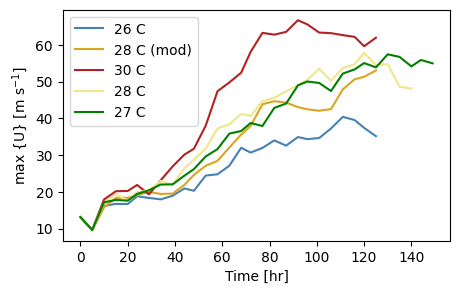

In [10]:
#%% Maximum wind speed in precursor simulations
iz = 0

plt.figure(figsize=(5,3))
for i in np.arange(len(Time_prec)):
    if i==0:
        tt = (ttime_prec0 - start_prec)/np.timedelta64(1,'h')
        uu = uv_prec[0:n_prec[0],iz,:,:] 
    elif i==1:
        tt = (ttime_prec1 - start_prec)/np.timedelta64(1,'h')
        uu = uv_prec[n_prec[0]:n_prec[0]+n_prec[1],iz,:,:]
    elif i==2:
        tt = (ttime_prec2 - start_prec)/np.timedelta64(1,'h')
        uu = uv_prec[n_prec[0]+n_prec[1]:n_prec[0]+n_prec[1]+n_prec[2],iz,:,:]
    elif i==3:
        tt = (ttime_prec3 - start_prec)/np.timedelta64(1,'h')
        uu = uv_prec[n_prec[0]+n_prec[1]+n_prec[2]:n_prec[0]+n_prec[1]+n_prec[2]+n_prec[3],iz,:,:]
    elif i==4:
        tt = (ttime_prec4 - start_prec)/np.timedelta64(1,'h')
        uu = uv_prec[n_prec[0]+n_prec[1]+n_prec[2]+n_prec[3]:,iz,:,:]
    plt.plot(tt,np.max(uu,axis=(1,2)),label=labels[i],color=colores[i])
    print(np.mean(np.max(uu,axis=(1,2))[(tt<=125) & (tt>100)]))
plt.legend()
# plt.xlim(0,tt[-1])
plt.ylabel(r'max {U} [m s$^{-1}$]')
plt.xlabel('Time [hr]')
plt.show()
plt.close()


38.91637
56.95747
51.76115
54.01406
52.882996


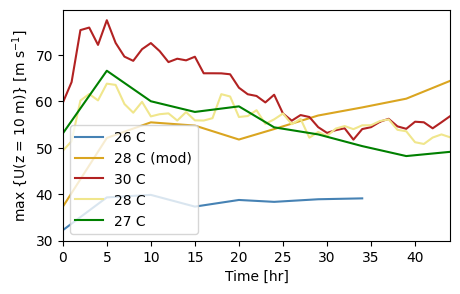

Maximum instantaneous wind speed in d01 is similar to max. 1-min sustained winds in d02


In [11]:
#%% Maximum wind speed in precursor simulations
iz = 0

plt.figure(figsize=(5,3))
for i in np.arange(len(Time_meso)):
    if i==0:
        tt = (ttime_meso0 - start_meso)/np.timedelta64(1,'h')
        uu = uv_meso[0:n_meso[0],iz,:,:] 
    elif i==1:
        tt = (ttime_meso1 - start_meso)/np.timedelta64(1,'h')
        uu = uv_meso[n_meso[0]:n_meso[0]+n_meso[1],iz,:,:]
    elif i==2:
        tt = (ttime_meso2 - start_meso)/np.timedelta64(1,'h')
        uu = uv_meso[n_meso[0]+n_meso[1]:n_meso[0]+n_meso[1]+n_meso[2],iz,:,:]
    elif i==3:
        tt = (ttime_meso3 - start_meso)/np.timedelta64(1,'h')
        uu = uv_meso[n_meso[0]+n_meso[1]+n_meso[2]:n_meso[0]+n_meso[1]+n_meso[2]+n_meso[3],iz,:,:]
    elif i==4:
        tt = (ttime_meso4 - start_meso)/np.timedelta64(1,'h')
        uu = uv_meso[n_meso[0]+n_meso[1]+n_meso[2]+n_meso[3]:,iz,:,:]
    plt.plot(tt,np.max(uu,axis=(1,2)),label=labels[i],color=colores[i])
    print(np.max(uu,axis=(1,2))[tt<=34][-1])
plt.legend()
plt.xlim(0,44)
plt.ylabel(r'max {U(z = 10 m)} [m s$^{-1}$]')
plt.xlabel('Time [hr]')
plt.show()
plt.close()

print("Maximum instantaneous wind speed in d01 is similar to max. 1-min sustained winds in d02")

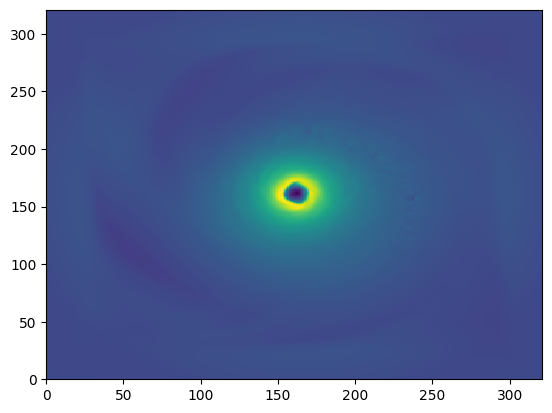

In [12]:
plt.pcolormesh(uv_meso[-1,iz,:,:])